# Visión por computadora - Lab 02
**Histogram of Gradients (HOG) de Dalal y Triggs, desde scratch.**

- Esteban Aldana
- Juan Angel Carrera
- José Mariano Reyes
- Luis Pedro Gonzalez Aldana

**Instalación de dependencias/librerías**

In [1]:
!pip install opencv-python-headless numpy


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Preparamos un directorio que recursos del laboratorio y resultados. 

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

if not os.path.exists('img'):
    os.makedirs('img')


## Inciso 1: 

Implementar una función en Python que acepte una imagen a colores, y haga las siguientes transformaciones
- Conversión de RGB a escala de grises,
- Reescalado (resize) a un tamaño (128k, 64k), (ratio 2:1)

In [5]:
from skimage import color, transform, io

def convert_and_resize(image, scale):
    # Verificar que el parámetro de escala sea al menos 1
    assert scale >= 1, "El parámetro de escala 'k' debe ser al menos 1."

    # Remover el canal alfa de la imagen (si existe)
    if image.shape[-1] == 4:
        image = image[...,:3]
    
    # Convertir de RGB a escala de grises
    gray_image = color.rgb2gray(image)
    
    # Reescalar la imagen a las dimensiones deseadas (128k x 64k)
    resized_image = transform.resize(gray_image, (128*scale, 64*scale), anti_aliasing=True)
    # 8-bit o float format

    if resized_image.dtype ==np.float64:
        resized_image = resized_image.astype(np.float32)
    else:
        resized_image = (resized_image * 255).astype(np.uint8)

    # Devolver la imagen reescalada
    return resized_image


In [6]:
image_path = './img/person.png'
image = io.imread(image_path)

scale = 50
resized_image = convert_and_resize(image, scale)
resized_image.dtype, resized_image.shape

(dtype('float32'), (6400, 3200))

In [13]:
resized_image.min(), resized_image.max()

(0.062815994, 1.0)

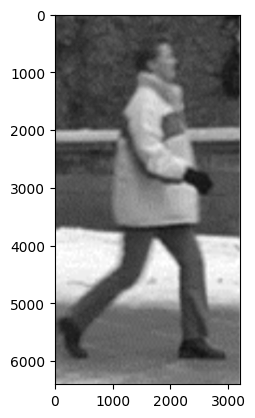

In [14]:
plt.imshow(resized_image, cmap="gray", vmin=0, vmax=1)

## Inciso 2:
Implementar una función en _Python_ que calcule la magnitud y ángulo del gradiente de una imagen en escala de grises.

Internamente su algoritmo debe calcular las correlaciones $G_x$ y $G_y$ de la imagen con los filtros de _Prewitt_ 

$$\nabla y = \begin{vmatrix}-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1
\end{vmatrix}$$


$$\nabla x = \begin{vmatrix}-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1
\end{vmatrix}$$

$$\mu = \sqrt{{G_x}^2 + {G_y}^2}$$

$$\theta = arctan2(-G_y, G_x) \cdot \frac{180}{\pi}$$


In [17]:
from scipy import ndimage

def gradient_magnitude_and_angle(image):
    # Definir los filtros de Prewitt para Gx y Gy
    Gx_kernel = np.array([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]])
    
    Gy_kernel = np.array([[-1, -1, -1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])
    
    # Cálculo de correlación entre gradientes
    Gx_conv = ndimage.convolve(image.astype(float), Gx_kernel, mode='constant', cval=0.0)
    Gy_conv = ndimage.convolve(image.astype(float), Gy_kernel, mode='constant', cval=0.0)

    # Calcular la magnitud y ángulo del gradiente
    magnitude = np.sqrt(Gx_conv**2 + Gy_conv**2)
    angle = np.arctan2(Gy_conv, Gx_conv) * (180 / np.pi)

    # normalizar el angulo
    angle[angle < 0] += 180
    angle[angle >= 180] -= 180

    return magnitude, angle

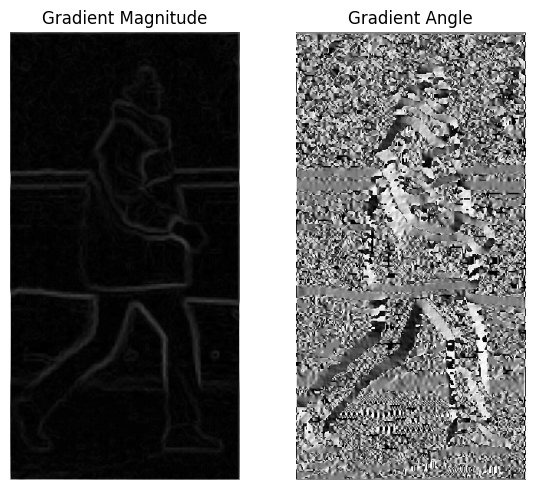

In [19]:
# Cargar la imagen en escala de grises
grayscale_image = io.imread(image_path, as_gray=True)
magnitude, angle = gradient_magnitude_and_angle(grayscale_image)


# Graficar ángulo y magnitud de gradiente
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 5))

# Magnitud
ax1.imshow(magnitude, cmap='gray')
ax1.set_title('Gradient Magnitude')
ax1.axis('off')

# Ángulo
ax2.imshow(angle, cmap='gray')  
ax2.set_title('Gradient Angle')
ax2.axis('off')

plt.tight_layout()
plt.show()

## Inciso 3

Implementar una función en Python que construya el stack de bloques de tamaño $\text{block size} × \text{block size}$, usando un _stride_ de `block size//2`. En este caso, `block_size` debe ser un parámetro indicado por el usuario (se sugiere que sea un múltiplo de 4, e.g. 4 × 4, 8 × 8, 16 × 16).

La entrada de la función debe ser 
- la imagen µ y θ obtenidas del gradiente
- block_size
- stride

Su función debe devolver 
- Dos stack o numpy arrays de tamaño $MN× \text{block size} × block size$, uno para la magnitud y otros para el ángulo del gradiente.


$$ M = \frac{128k}{stride} - 1$$

$$N = \frac{64k}{stride} - 1$$



In [20]:
def build_blocks(magnitude, angle, block_size, stride):

    # Calcular las dimensiones de los stacks de bloques basado en las dimensiones de las imágenes y el stride
    M = (magnitude.shape[0] - block_size) // stride + 1
    N = (magnitude.shape[1] - block_size) // stride + 1
        
    # Inicializar los stacks de bloques para la magnitud y el ángulo
    blocks_magnitude = np.zeros((M, N, block_size, block_size))
    blocks_angle = np.zeros((M, N, block_size, block_size))
    # Construir los stacks de bloques

    for i in range(M):
        for j in range(N):
            row = i * stride
            col = j * stride
            blocks_magnitude[i, j] = magnitude[row:row+block_size, col:col+block_size]
            blocks_angle[i, j] = angle[row:row+block_size, col:col+block_size]
            
    return blocks_magnitude, blocks_angle

In [21]:
# Construir los stacks de bloques para la magnitud y el ángulo
block_size = 8  # Este valor puede ajustarse
stride = block_size // 2
blocks_magnitude, blocks_angle = build_blocks(magnitude, angle, block_size, stride)


# Imprimir las dimensiones de los stacks de bloques
print(f"Dimensiones de los bloques de magnitud: {blocks_magnitude.shape}")
print(f"Dimensiones de los bloques de ángulo: {blocks_angle.shape}")

Dimensiones de los bloques de magnitud: (145, 74, 8, 8)
Dimensiones de los bloques de ángulo: (145, 74, 8, 8)


## Inciso 4
Implementar una función en Python que construya el histograma de gradientes, a partir de los stacks de bloques µ y θ. La construcción del histograma debe recibir un número de bines $n$ indicado por el usuario (se sugiere usar $n = 9$). 

Internamente la función deberá calcular los centros de cada bin, y hacer un barrido de cada uno de los bloques en los stacks. Para cada bloque, debe calcularse un vector (numpy array de tamaño $n$) donde se guardará la información de su respectivo histograma

La salida de la función debe ser un numpy array $H$ de tamaño $MN × n$ con la información de los cada histograma. Los histogramas deberán normalizarse utilizando la norma euclideana:

$$H[i] = \frac{H[i]}{\sqrt{||H[i]||^2 + \epsilon}}$$


In [22]:
def calculate_histogram(blocks_magnitude, blocks_angle, n_bins):
    block_shape = blocks_magnitude.shape 
    M, N = block_shape[0], block_shape[1]


    histograms = np.zeros((M, N, n_bins))
    bin_edges = np.linspace(0, 180, n_bins+1)

    for i in range(M):
        for j in range(N):
            block_magnitude = blocks_magnitude[i, j].flatten()
            block_angle = blocks_angle[i, j].flatten()
            
            hist, _ = np.histogram(block_angle, bins=bin_edges, weights=block_magnitude)
            norm = np.linalg.norm(hist)
            histograms[i, j, :] = hist / norm if norm != 0 else hist

    return histograms

In [23]:
n_bins = 9
H = calculate_histogram(blocks_magnitude, blocks_angle, n_bins)
H.shape

(145, 74, 9)

## Inciso 5

Escribir una función en python que a cada bloque en el stack, convierta el histograma de ese bloque a un representación visual. Esta representación visual será una matriz de tamaño $block size × block size$. Esta imagen se trabaja como una imagen con fondo negro. Por cada índice en el histograma de dicho bloque, $i = 1, 2, . . . , n$, se dibujará una línea con ángulo en el centroide $C_i$ del bin $i$, y de magnitud o intensidad igual al valor del histograma en el bin $i$.


Construir una imagen de direcciones que dibuje los histogramas visuales de cada bloque. (Aquí se sugiere usar un $block size = 8$ y un $stride = block size = 8$). 


In [24]:

def histogram_visualization(histograms, block_size, n_bins):
    H_shape = histograms.shape  
    M, N = H_shape[0], H_shape[1]


    visual_image = np.zeros((M*block_size, N*block_size))

    degrees = 180 / n_bins

    for i in range(M):
        for j in range(N):
            block_histogram = histograms[i, j]
            for bin_idx in range(n_bins):
                # Calcula el ángulo y magnitud por línea
                angle = degrees * (bin_idx + 0.5)  # Ángulo en el centro del bin
                magnitude = block_histogram[bin_idx] * block_size  # Usa la msgnitud como el tamaño de la línea

                theta = np.deg2rad(angle)  # Conversión a radianes
                x_center = j * block_size + block_size // 2
                y_center = i * block_size + block_size // 2
                dx = magnitude * np.cos(theta) / 2
                dy = magnitude * np.sin(theta) / 2
                # Dibuja la línea
                cv2.line(visual_image,
                         (int(x_center - dx), int(y_center - dy)),
                         (int(x_center + dx), int(y_center + dy)),
                         color=1, 
                         thickness=1)

    return visual_image

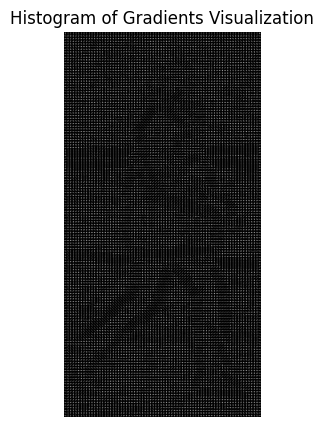

In [25]:

visual_block_size = 16
visual_stride = visual_block_size 


H_viz = histogram_visualization(H, visual_block_size, n_bins)


plt.figure(figsize=(10, 5))
plt.imshow(H_viz, cmap='gray')
plt.title('Histogram of Gradients Visualization')
plt.axis('off')
plt.show()


## Inciso 6

Comparar sus resultados del algoritmo anterior (Ejercicios 1 a 5), contra la función de `scikit-image hog`.

### Implementción con scikit-image hog

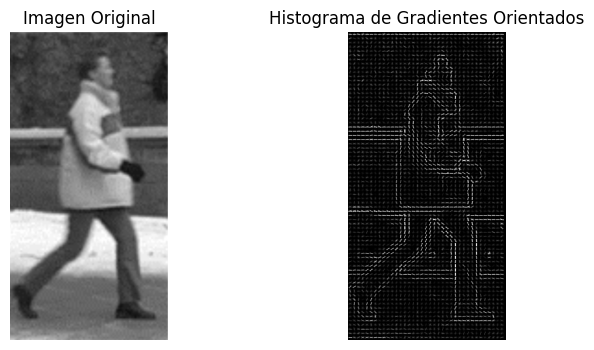

In [27]:
from skimage.feature import hog
from skimage import data, exposure

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block, visualize=True, channel_axis=-1)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title('Histograma de Gradientes Orientados')
plt.axis('off')

plt.show()


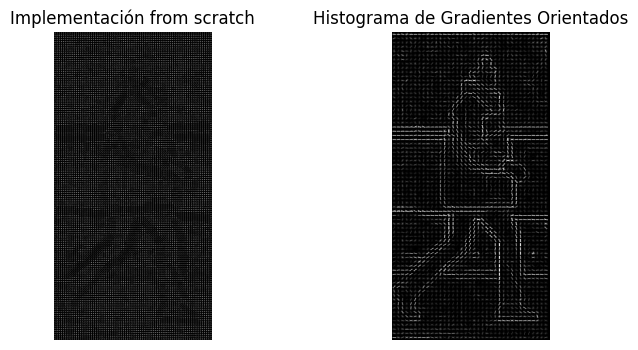

In [28]:
plt.figure(figsize=(8, 4))
H_viz

plt.subplot(121)
plt.imshow(H_viz, cmap='gray')
plt.title('Implementación from scratch')
plt.axis('off')

plt.subplot(122)
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title('Histograma de Gradientes Orientados')
plt.axis('off')

plt.show()

### Comparativa from scratch v sckikit

En términos de eficiencia y velocidad, el algoritmo from scratch no tiene mayor problema para esta imagen en particular. Por otra parte, ambos métodos producen resultados visuales similares, donde se pueden identificar las direcciones predominantes de los gradientes en la imagen, lo que nos lleva igualmente al reconocimiento de bordes dentro de la imagen. La función hog de scikit sin embargo muestra con mayor claridad la silueta y no pierde algunos detalles más pequeños de la silueta como las manos o rostro. Dicha diferencia no está tan asociada a una mala implementación per se, sin embargo podría mejorar el ajuste de algunos hiperparametros, algo en lo que la librería scikit learn debe aber trabajao ya con su función hog. Para alcanzar mejores resultados podría ajustarse el número de orientaciones, el tamaño de celda y el tamaño de bloque.

## Inciso 7

Implementar un método de detección de personas, utilizando la librería de OpenCV. Mostrar resultados de su detecci´on con diferentes imágenes de su elección.


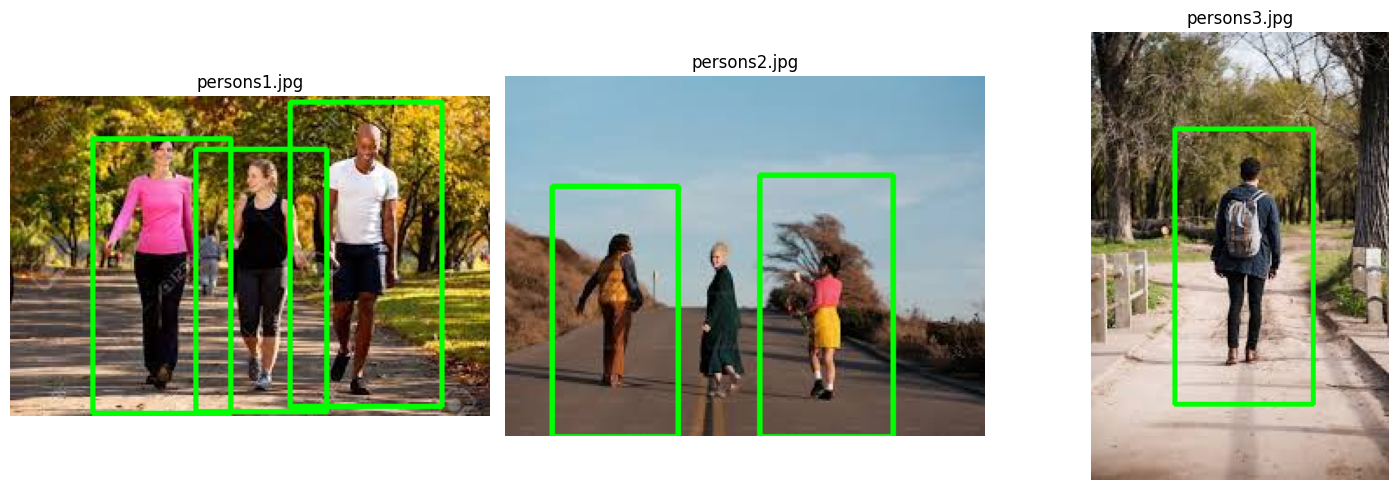

In [29]:
folder_path = './img/'
image_files = ['persons1.jpg', 'persons2.jpg', 'persons3.jpg']

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())


plt.figure(figsize=(15, 5))
total_images = len(image_files)


for idx, image_file in enumerate(image_files, start=1):
    image_path = os.path.join(folder_path, image_file)
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_file}")
        continue
    
    locations, _ = hog.detectMultiScale(image, winStride=(8, 8), padding=(8, 8), scale=1.05)
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for (x, y, w, h) in locations:
        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.subplot(1, total_images, idx)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(image_file)

plt.tight_layout()
plt.show()
